## GDELT Data Load 

### 1) GDELT Header File
The daily GDELT csv files do not contain a header. The data header file is separately maintained and the column names are parsed into the correct format as a first step. 
- Column data: https://www.gdeltproject.org/data/lookups/CSV.header.dailyupdates.txt

In [1]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import bs4
import tensorflow as tf
import sys 

In [2]:
#read the header file for the GDELT data
columns = pd.read_excel('CSV.header.fieldids.xlsx')

In [3]:
#write all column names into a list for later processing. This list will be used to process all GDELT data after 2013
column_names = list(columns)

In [4]:
#remove the last item from the column_names list as GDELT files prior to 2013 come without the last column, the Source URL
old_column_names = column_names.copy()
del old_column_names[-1]

### 2) GDELT Website Scraper
A website scraper is built to autmatically extract the daily csv files, removing the need to manually download all files and read them into the notebook.
- Conflict Data: http://data.gdeltproject.org/events/index.html

In [ ]:
#retrieve the HTML code behind the GDELT website with the beautiful soup library
link = 'http://data.gdeltproject.org/events/index.html'

sys.setrecursionlimit(100000) 

def get_html_code(link):
    web_pages = requests.get(link).text
    soup = bs4.BeautifulSoup(web_pages, 'html.parser')
    return soup

soup = get_html_code(link)

In [ ]:
#further filter the created object on the anchor tag to retrieve the URLs for the individual files
def get_csv_files(soup):
    return soup.find_all('a')

get_csv_files(get_html_code(url))

In [ ]:
#indicate the number of files that should be laoded, with 0 being the most recent file
x = 0
y = 3500 #1500

In [ ]:
#create the complete download link for each file by extracing the relevant information from the anchor tag and concatenating
#it with the base URL 
 
all_url = soup.find_all('a',href = True)
all_url = all_url[3:]
download_links = []
base_url = 'http://data.gdeltproject.org/events/'

for i in range(x,y):
    download_links.append(base_url + all_url[i]['href'])
    

In [ ]:
#with this cell, it can be checked starting at which index of the download_links list files in the old format are present. 
#this is relevant for the data load as the old files have 57 instead of 58 columns 
#the download_links list changes each day when executed as a new file gets added each day
download_links.index('http://data.gdeltproject.org/events/20130401.export.CSV.zip')


In [ ]:
#define correct type of the attributes to speed up processing for the dataframe creation
variables = {'MonthYear':int,
             'SQLDATE': int, 
             'EventCode': str, 
             'Year': int,
             'QuadClass': int,
             'GoldsteinScale': float,
             'ActionGeo_CountryCode': str, 
             'ActionGeo_ADM1Code': str,
             'Actor1Code': str, 
             'Actor2Code': str,
             }

In [ ]:
#select relevant columns and write them into a list 

columns = ['SQLDATE', 'MonthYear', 'Year', 'EventCode', 'QuadClass',
       'GoldsteinScale','ActionGeo_CountryCode', 'ActionGeo_ADM1Code', 'Actor1Code', 'Actor2Code']

In [ ]:
#write the country abbreviations for the selected countries into a list as well 
country_list = ['WI', 'MR', 'ML', 'SG', 'GA', 'PU', 'GV', 'EK', 'SL', 'LI', 'IV', 'UV', 'GH', 'TO', 'BN']

In [ ]:
#function to get download links for the specified timeframe

def downloads(soup_object, range_start, range_end):

    all_links = soup_object.find_all('a',href = True)
    all_links = all_links[3:]
    urls = []
    download_links = []
    base_url = 'http://data.gdeltproject.org/events/'

    for i in range(range_start,range_end):
        download_links.append(base_url + all_links[i]['href'])#urls[i])
    
    return download_links

In [ ]:
#function to load data into dataframes for the specified timeframe

#downloading conflicts for all the relevant countries and filter on Quad Class and Goldstein Scale 
### NOTE: use either column_names or column_names_old 

def load_data(download_links, range_start, range_end): 
    final_df = pd.DataFrame()
    dataframes = []
    fields = columns

    for i in range(range_start,range_end):
        print(i)
        df_temp = pd.read_csv(download_links[i],sep='\t',error_bad_lines=False, names = column_names, usecols = columns, dtype = variables)
        df_temp = df_temp[(df_temp['ActionGeo_CountryCode'].isin(country_list)) & 
                          ((df_temp['QuadClass'] == 3) | (df_temp['QuadClass'] == 4)) & 
                         ((df_temp['GoldsteinScale'] < -5))]
    
        df_temp = df_temp.drop_duplicates(keep='first')
        dataframes.append(df_temp)
        df_temp = []
    final_df = pd.concat(dataframes)
    
    return final_df

In [ ]:
#loading the data for the first 7 years (2022 - 2014) and saving the resulting dataframe as a pickle file for an optimized 
#read/write performance

z = 7

for j in range(0, z):
    x = 365*j
    y = 365+ 365*j
    
    links = downloads(soup, x, y)
    df = load_data(links, 0, 365)
    
    path_yearly = 'df' + str(j) + 'b' + '.pickle'
    
    df.to_pickle(path = path_yearly)

In [ ]:
#additional files that are not captured above until 20130401 are loaded into the respective dataframes and pickle files
links = downloads(soup, 2920, 3431)
print(links[0])
print(links[-1])

df = load_data(links, 0, 507)
path_yearly = 'df' + str(8) + 'b' + '.pickle'
df.to_pickle(path = path_yearly)

links = downloads(soup, 3427, 3431)
df = load_data(links, 0, 4)
path_yearly = 'df' + str(8) + 'c' + '.pickle'
df.to_pickle(path = path_yearly)

In [ ]:
#function to load data into dataframes for the specified timeframe in the old file format
#downloading conflicts for all the relevant countries and filter on Quad Class and Goldstein Scale 

def load_old_data(download_links, range_start, range_end): 
    final_df = pd.DataFrame()
    dataframes = []
    fields = columns

    for i in range(range_start,range_end):
        print(i)
        df_temp = pd.read_csv(download_links[i],sep='\t',error_bad_lines=False, names = old_column_names, usecols = columns, dtype = variables)
        df_temp = df_temp[(df_temp['ActionGeo_CountryCode'].isin(country_list)) & 
                          ((df_temp['QuadClass'] == 3) | (df_temp['QuadClass'] == 4)) & 
                         ((df_temp['GoldsteinScale'] < -5))]
    
        df_temp = df_temp.drop_duplicates(keep='first')
        dataframes.append(df_temp)
        df_temp = []
    final_df = pd.concat(dataframes)
    
    return final_df

In [ ]:
#download the old data files and write them into the respective pickle file

links = downloads(soup, 3431, 3544)
df = load_old_data(links, 0, 113)
path_yearly = 'df' + str(9) + "b" + '.pickle'
    
df.to_pickle(path = path_yearly)


In [ ]:
#read the files that were created in the Data Loading Python Notebook into separate dataframes
df0 = pd.read_pickle('df0b.pickle')
df1 = pd.read_pickle('df1b.pickle')
df2 = pd.read_pickle('df2b.pickle')
df3 = pd.read_pickle('df3b.pickle')
df4 = pd.read_pickle('df4b.pickle')
df5 = pd.read_pickle('df5b.pickle')
df6 = pd.read_pickle('df6b.pickle')
df7 = pd.read_pickle('df7b.pickle')
df8 = pd.read_pickle('df8b.pickle')
df8b = pd.read_pickle('df8c.pickle')
df9 = pd.read_pickle('df9b.pickle')

In [ ]:
#merge all dataframes & check the total length
df_complete = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8, df8b, df9], axis=0)
len(df_complete)

In [ ]:
#export the downloaded and merged dataset into one new dataframe which is used as an input for the 2nd notebook
df_complete.to_pickle(path = 'df_complete.pickle')

### 3) Scatterplot for Goldstein Scale and Quad Class
To get an idea of how Goldstein score and Quad Class are related, a scatterplot between both variables is created based on the GDELT file for one day. 

In [12]:
#read one GDELT file into a dataframe
daily_url = 'http://data.gdeltproject.org/events/20220927.export.CSV.zip'

df = pd.read_csv(daily_url,sep='\t',error_bad_lines=False,names=column_names)

C:\Users\Shadow\AppData\Local\Temp\ipykernel_6780\2715337392.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(daily_url,sep='\t',error_bad_lines=False,names=column_names)


In [14]:
#replace numeric codes with the descriptions
df['QuadClass'].replace({1: "Verbal Cooperation", 2: "Material Cooperation", 
                         3: "Verbal Conflict", 4: "Material Conflict"}, inplace = True)

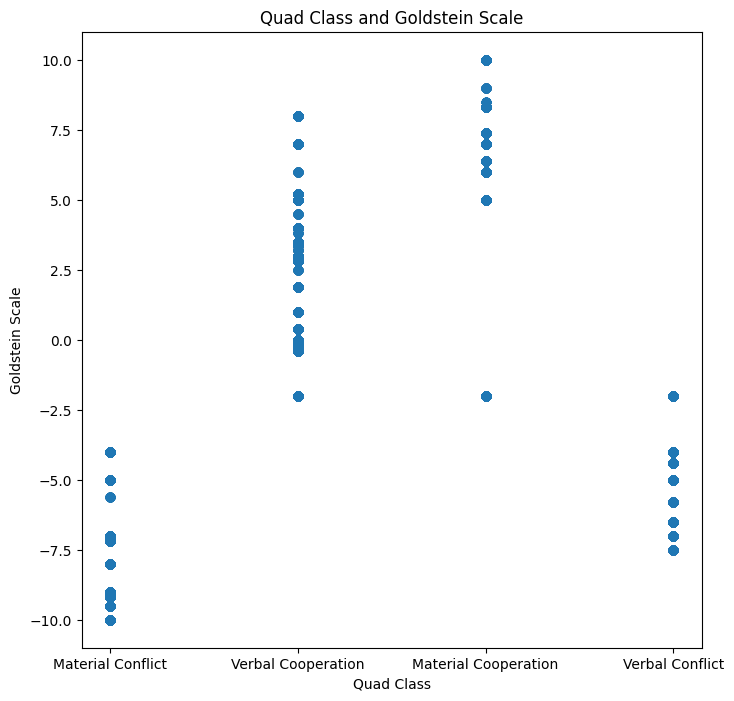

In [16]:
#create scatterplot QuadClass by Goldstein Scale 

fig = plt.figure(figsize = (8,8))

plt.scatter(df['QuadClass'], df['GoldsteinScale'])
plt.title('Quad Class and Goldstein Scale')
plt.xlabel('Quad Class')
plt.ylabel('Goldstein Scale')
plt.show() 